In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print("Training Data Info:")
print(train_df.info())

print("\nTraining Data Statistical Summary:")
print(train_df.describe())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   i

In [3]:
missing_values = train_df.isnull().sum()
print(missing_values[missing_values > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [4]:
none_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
    'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'BsmtQual', 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'MasVnrType'
]

for col in none_cols:
    train_df[col] = train_df[col].fillna('None')

In [5]:
zero_cols = ['GarageArea', 'GarageCars', 'MasVnrArea','GarageYrBlt']
for col in zero_cols:
    train_df[col] = train_df[col].fillna(0)

train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])


In [7]:
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])


Series([], dtype: int64)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


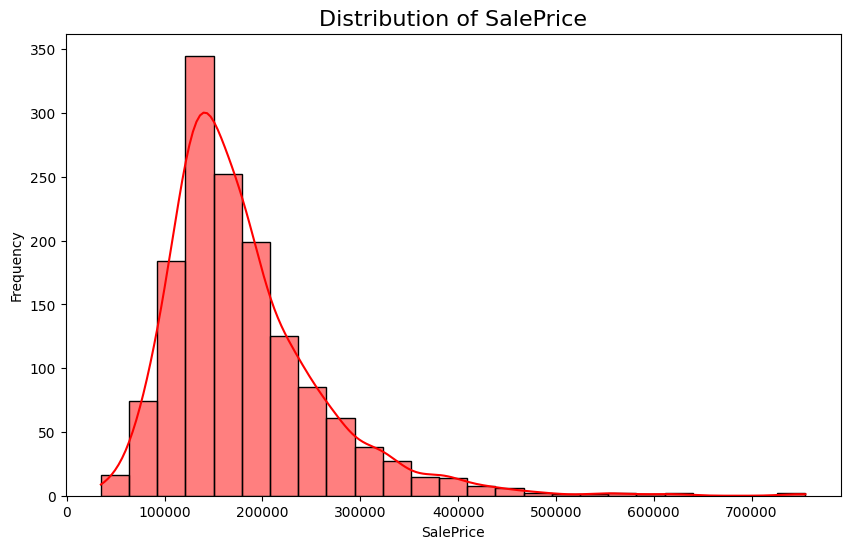

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(10,6))
sns.histplot(train_df['SalePrice'], kde=True, bins=25, color="red")
plt.title("Distribution of SalePrice", fontsize=16)
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

In [9]:
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


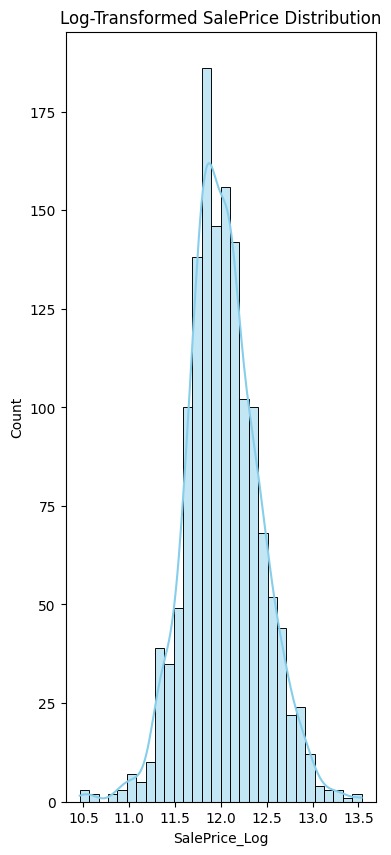

Skewness: 0.121335
Kurtosis: 0.809532


In [10]:
train_df["SalePrice_Log"]=np.log(train_df["SalePrice"])
plt.figure(figsize=(4,10))
sns.histplot(train_df["SalePrice_Log"],kde=True,bins=30,color="skyblue")
plt.title("Log-Transformed SalePrice Distribution")
plt.show()
print("Skewness: %f" % train_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log'].kurt())

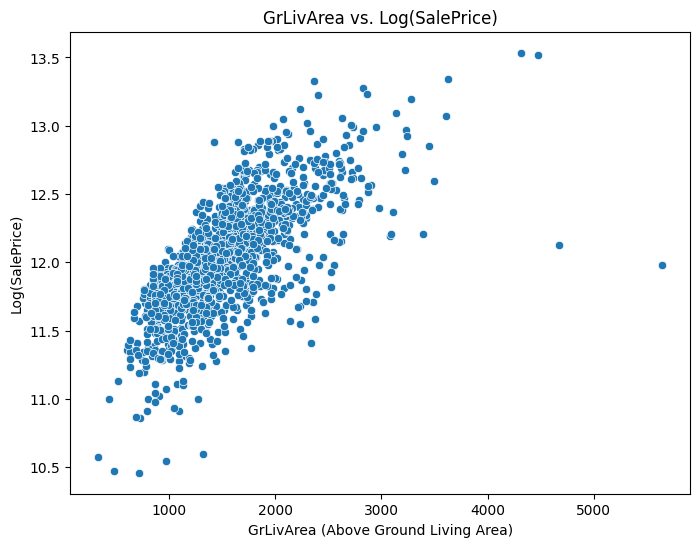

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=train_df["GrLivArea"],y=train_df["SalePrice_Log"])
plt.xlabel("GrLivArea (Above Ground Living Area)")
plt.ylabel("Log(SalePrice)")
plt.title("GrLivArea vs. Log(SalePrice)")
plt.show()

In [12]:
outliers=train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)]
print("Outliers found: \n",outliers[['GrLivArea', 'SalePrice']])
train_df=train_df.drop(outliers.index)

Outliers found: 
       GrLivArea  SalePrice
523        4676     184750
1298       5642     160000


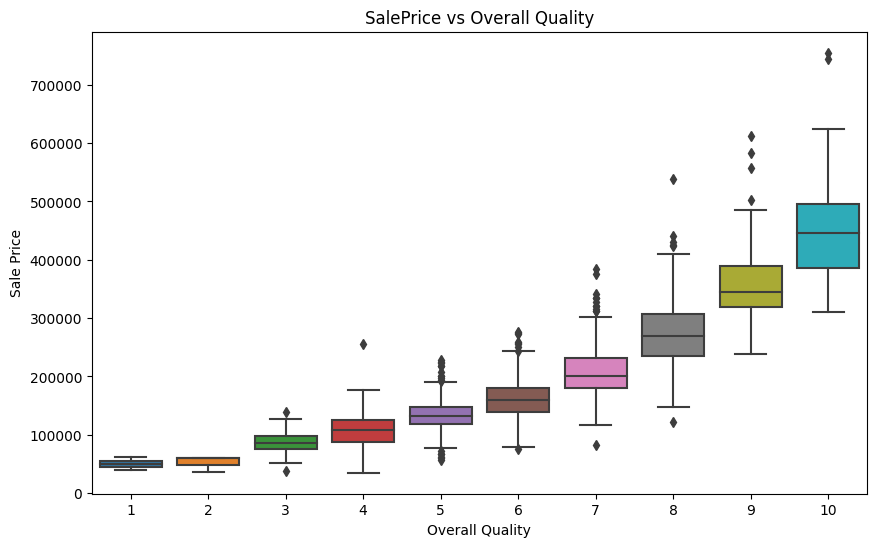

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_df)
plt.title("SalePrice vs Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price")
plt.show()

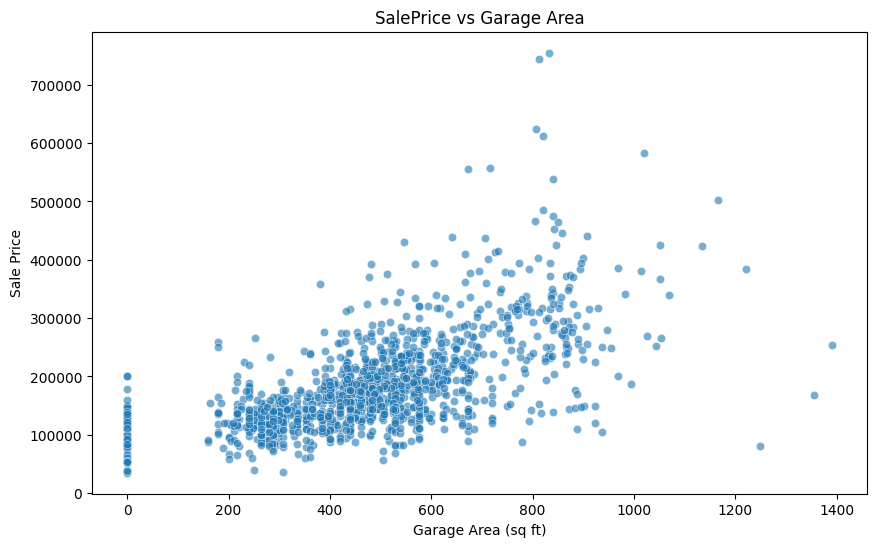

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="GarageArea", y="SalePrice", data=train_df, alpha=0.6)
plt.title("SalePrice vs Garage Area")
plt.xlabel("Garage Area (sq ft)")
plt.ylabel("Sale Price")
plt.show()

In [15]:
train_df.isnull().sum().sort_values(ascending=False).head(20)

Id              0
GarageCars      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageFinish    0
dtype: int64

In [16]:
train_df=pd.get_dummies(train_df,drop_first=True)
print("Shape after encoding:", train_df.shape)
print(train_df.head())
print(train_df.info())

Shape after encoding: (1458, 261)
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0         706  ...           False           False   
1          1976         0.0         978  ...           False           False   
2          2002       162.0         486  ...           False           False   
3          1970         0.0         216  ...           False           False   
4          2000       350.0         655  ...           False           False   

   S

In [17]:
from sklearn.preprocessing import StandardScaler
X = train_df.drop(columns=["SalePrice", "Id","SalePrice_Log"])
Y = train_df["SalePrice_Log"]
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Scaled dataset shape:", X_scaled.shape)
print(X_scaled.head())

Scaled dataset shape: (1458, 258)
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073426    -0.232605 -0.203934     0.658506    -0.517649   1.052959   
1   -0.871868     0.466313 -0.087252    -0.068293     2.177825   0.158428   
2    0.073426    -0.092822  0.080162     0.658506    -0.517649   0.986698   
3    0.309749    -0.465578 -0.092325     0.658506    -0.517649  -1.862551   
4    0.073426     0.652691  0.385566     1.385305    -0.517649   0.953567   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0      0.880362    0.523937    0.617283   -0.288867  ...       -0.058661   
1     -0.428115   -0.570739    1.245719   -0.288867  ...       -0.058661   
2      0.831900    0.334044    0.108989   -0.288867  ...       -0.058661   
3     -0.718888   -0.570739   -0.514826   -0.288867  ...       -0.058661   
4      0.734975    1.384039    0.499451   -0.288867  ...       -0.058661   

   SaleType_ConLw  SaleType_New  SaleType_Oth 

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y,test_size=0.2,random_state=42)


In [19]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_log = model.predict(X_test)
safe_log_predictions = np.clip(y_pred_log, a_min=-15, a_max=20)
predictions_untransformed = np.exp(safe_log_predictions)
y_test_untransformed = np.exp(y_test)
rmse = np.sqrt(mean_squared_error(y_test_untransformed, predictions_untransformed))
r_squared = r2_score(y_test_untransformed, predictions_untransformed)
print("Final RMSE:", rmse)
print("Final R-squared:", r_squared)

Final RMSE: 56764620.06491264
Final R-squared: -583340.9866762181


In [21]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.001, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_log = lasso.predict(X_test)
safe_log_predictions = np.clip(y_pred_log, a_min=-15, a_max=20)
predictions_untransformed = np.exp(safe_log_predictions)
y_test_untransformed = np.exp(y_test)
rmse = np.sqrt(mean_squared_error(y_test_untransformed, predictions_untransformed))
r_squared = r2_score(y_test_untransformed, predictions_untransformed)
print("Final RMSE:", rmse)
print("Final R-squared:", r_squared)

Final RMSE: 20743.639145983667
Final R-squared: 0.922099963104898


In [41]:

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

none_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
    'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'BsmtQual', 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'MasVnrType'
]
for col in none_cols:
    if col in test.columns:
        test[col] = test[col].fillna('None')

zero_cols = ['GarageArea', 'GarageCars', 'MasVnrArea','GarageYrBlt']
for col in zero_cols:
    if col in test.columns:
        test[col] = test[col].fillna(0)

if 'LotFrontage' in test.columns and 'Neighborhood' in test.columns:
    test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )

if 'Electrical' in test.columns:
    test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

y = np.log(train["SalePrice"])
X = train.drop(["SalePrice", "Id"], axis=1)
test_ids = test["Id"]
test = test.drop(["Id"], axis=1)

X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
X, test = X.align(test, join="left", axis=1, fill_value=0)

X = X.fillna(0)
test = test.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

model = Lasso(alpha=0.001, max_iter=10000)
model.fit(X_scaled, y)

preds = model.predict(test_scaled)
preds = np.exp(np.clip(preds, a_min=-15, a_max=20))

submission = pd.DataFrame({"Id": test_ids, "SalePrice": preds})
submission.to_csv("submission.csv", index=False)
